In [1]:
import pandas as pd

# load the csv file into a pandas dataframe
df = pd.read_csv('output_dataset.csv')

# print the first few rows of the dataframe to check if the data is loaded correctly
print(df.head())


   room_id      start_timestamp  number_of_astronauts
0        5  2022-01-01 00:00:00                    18
1        5  2022-01-01 00:15:00                    18
2        5  2022-01-01 00:30:00                    18
3        5  2022-01-01 00:45:00                    18
4        5  2022-01-01 01:00:00                    18


In [2]:
import numpy as np
from datetime import datetime

# convert start_timestamp to numerical format
df['initial_timestamp'] = pd.to_datetime(df['start_timestamp'])
df['start_timestamp'] = pd.to_datetime(df['start_timestamp'])
df['start_timestamp'] = df['start_timestamp'].apply(lambda x: x.timestamp())

# extract hour and minute from start_timestamp
df['hour'] = df['start_timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
df['minute'] = df['start_timestamp'].apply(lambda x: datetime.fromtimestamp(x).minute)

# round number_of_astronauts to nearest integer
df['number_of_astronauts'] = np.round(df['number_of_astronauts']).astype(int)

# print the first few rows of the dataframe to check if the preprocessing is done correctly
print(df.head())


   room_id  start_timestamp  number_of_astronauts   initial_timestamp  hour  \
0        5     1.640995e+09                    18 2022-01-01 00:00:00     1   
1        5     1.640996e+09                    18 2022-01-01 00:15:00     1   
2        5     1.640997e+09                    18 2022-01-01 00:30:00     1   
3        5     1.640998e+09                    18 2022-01-01 00:45:00     1   
4        5     1.640999e+09                    18 2022-01-01 01:00:00     2   

   minute  
0       0  
1      15  
2      30  
3      45  
4       0  


In [5]:
from sklearn.model_selection import train_test_split

# split the dataset into training, retrain and testing datasets
train_df, retrain_df = train_test_split(df, test_size=0.3, random_state=42)
retrain_df, test_df = train_test_split(retrain_df, test_size=0.5, random_state=42)

# print the number of rows in each dataset
print("Number of rows in training dataset:", len(train_df))
print("Number of rows in retrain dataset:", len(retrain_df))
print("Number of rows in testing dataset:", len(test_df)) 


Number of rows in training dataset: 122307
Number of rows in retrain dataset: 26209
Number of rows in testing dataset: 26209


In [6]:
from sklearn.preprocessing import StandardScaler

# scale the input features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[['room_id', 'hour', 'minute']])
retrain_features = scaler.transform(retrain_df[['room_id', 'hour', 'minute']])
test_features = scaler.transform(test_df[['room_id', 'hour', 'minute']])

# prepare the target variable
train_target = train_df['number_of_astronauts']
retrain_target = retrain_df['number_of_astronauts']
test_target = test_df['number_of_astronauts']

# reshape the input features to 3D tensor for input to RNN model
train_features = train_features.reshape((train_features.shape[0], 1, train_features.shape[1]))
retrain_features = retrain_features.reshape((retrain_features.shape[0], 1, retrain_features.shape[1]))
test_features = test_features.reshape((test_features.shape[0], 1, test_features.shape[1]))

print("Shape of training input features:", train_features.shape)
print("Shape of training target variable:", train_target.shape)
print("Shape of retrain input features:", retrain_features.shape)
print("Shape of retrain target variable:", retrain_target.shape)
print("Shape of testing input features:", test_features.shape)
print("Shape of testing target variable:", test_target.shape)

Shape of training input features: (122307, 1, 3)
Shape of training target variable: (122307,)
Shape of retrain input features: (26209, 1, 3)
Shape of retrain target variable: (26209,)
Shape of testing input features: (26209, 1, 3)
Shape of testing target variable: (26209,)


In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# define the RNN model
model = Sequential()
model.add(LSTM(32, input_shape=(train_features.shape[1], train_features.shape[2]), return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))

# compile the model
model.compile(loss='mse', optimizer='adam')


2023-03-30 12:06:51.309153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 12:07:02.101649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# train the model
history = model.fit(train_features, train_target, epochs=5, batch_size=16, validation_data=(retrain_features, retrain_target))

# evaluate the model on retrain dataset
retrain_score = model.evaluate(retrain_features, retrain_target, verbose=0)
print('Retrain Score: %.5f MSE (%.5f RMSE)' % (retrain_score, np.sqrt(retrain_score)))


Epoch 1/5
7645/7645 [==============================] - 41s 5ms/step - loss: 17.9378 - val_loss: 7.0929
Epoch 2/5
7645/7645 [==============================] - 34s 4ms/step - loss: 5.5525 - val_loss: 4.8721
Epoch 3/5
7645/7645 [==============================] - 42s 5ms/step - loss: 4.6192 - val_loss: 4.5465
Epoch 4/5
7645/7645 [==============================] - 42s 6ms/step - loss: 4.4286 - val_loss: 4.4470
Epoch 5/5
7645/7645 [==============================] - 37s 5ms/step - loss: 4.3337 - val_loss: 4.3860
Retrain Score: 4.38601 MSE (2.09428 RMSE)


In [24]:
import datetime as dt

# create a new dataframe to store the predicted number of occupants
pred_df = pd.DataFrame(columns=['room_id', 'start_timestamp', 'number_of_astronauts'])

# define the start and end timestamp for the day we want to predict
start = pd.Timestamp('2022-12-01')
end = start + pd.Timedelta(days=1)

# loop through each room_id and predict the number of occupants for every 15 minute interval
for room_id in df['room_id'].unique():
    # create a new dataframe for the current room_id
    room_df = pd.DataFrame(columns=['room_id', 'start_timestamp', 'number_of_astronauts'])
    
    # loop through every 15 minute interval in the day
    for timestamp in pd.date_range(start=start, end=end, freq='15T'):
        # create a new row for the current timestamp and room_id
        row = {'room_id': room_id, 'start_timestamp': timestamp.timestamp(), 'number_of_astronauts': 0}
        
        # get the hour and minute from the timestamp
        hour = timestamp.hour
        minute = timestamp.minute
        
        # scale the input features
        input_feature = scaler.transform([[room_id, hour, minute]])
        
        # reshape the input feature to 3D tensor for input to RNN model
        input_feature = input_feature.reshape((1, 1, input_feature.shape[1]))
        
        # predict the number of occupants using the trained RNN model
        prediction = model.predict(input_feature)
        
        # round the prediction to the nearest integer
        prediction = int(round(prediction[0][0]))
    
        # set the number_of_astronauts for the current row to the predicted value
        row['number_of_astronauts'] = prediction
    
        # add the row to the room_df
        room_df = room_df.append(row, ignore_index=True)

        # add the room_df to the pred_df
    pred_df = pred_df.append(room_df, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:45

1/1 [==============================] - 0s 24ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 24ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 24ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 29ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append(room_df, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 24ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 24ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 30ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - ETA: 0s

/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 24ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 30ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 35ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append(room_df, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 30ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 30ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 30ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 24ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append(room_df, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 30ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 26ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:45

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append(room_df, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 28ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 23ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 27ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 29ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 20ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 22ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 21ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 31ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.

1/1 [==============================] - 0s 48ms/step


/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  room_df = room_df.append(row, ignore_index=True)
/var/folders/g_/mmqgkbcx0qn0r2j_wxv7rf2m0000gn/T/ipykernel_50021/4215304269.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_df = pred_df.append(room_df, ignore_index=True)


In [25]:
pred_df['start_timestamp'] = pd.to_datetime(pred_df['start_timestamp'], unit='s')

In [26]:
print(pred_df.head(10))

   room_id     start_timestamp  number_of_astronauts
0      5.0 2022-12-01 00:00:00                  16.0
1      5.0 2022-12-01 00:15:00                  17.0
2      5.0 2022-12-01 00:30:00                  18.0
3      5.0 2022-12-01 00:45:00                  17.0
4      5.0 2022-12-01 01:00:00                  16.0
5      5.0 2022-12-01 01:15:00                  17.0
6      5.0 2022-12-01 01:30:00                  18.0
7      5.0 2022-12-01 01:45:00                  17.0
8      5.0 2022-12-01 02:00:00                  16.0
9      5.0 2022-12-01 02:15:00                  18.0


In [27]:
from sklearn.metrics import mean_squared_error

# make predictions on testing dataset
test_predictions = model.predict(test_features)

# calculate MSE and RMSE for testing dataset
test_mse = mean_squared_error(test_target, test_predictions)
test_rmse = np.sqrt(test_mse)
print('Testing MSE: %.5f' % (test_mse))
print('Testing RMSE: %.5f' % (test_rmse))


820/820 [==============================] - 2s 2ms/step
Testing MSE: 4.25686
Testing RMSE: 2.06322


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline


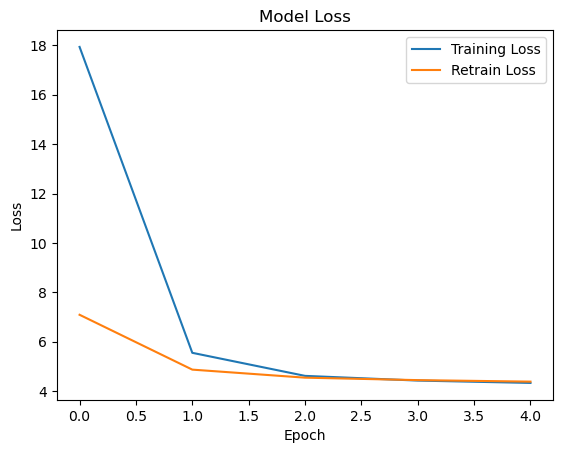

In [29]:
# plot training and retrain loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Retrain Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# select the date to plot
plot_date = '2022-12-01'

# filter the actual dataset and predicted dataset for the selected date
actual_df = df[df['initial_timestamp'].dt.date == pd.to_datetime(plot_date).date()]
pred_df = pred_df[pred_df['start_timestamp'].dt.date == pd.to_datetime(plot_date).date()]

In [31]:

print(pred_df)

     room_id     start_timestamp  number_of_astronauts
0        5.0 2022-12-01 00:00:00                  16.0
1        5.0 2022-12-01 00:15:00                  17.0
2        5.0 2022-12-01 00:30:00                  18.0
3        5.0 2022-12-01 00:45:00                  17.0
4        5.0 2022-12-01 01:00:00                  16.0
..       ...                 ...                   ...
479      3.0 2022-12-01 22:45:00                   0.0
480      3.0 2022-12-01 23:00:00                   0.0
481      3.0 2022-12-01 23:15:00                   0.0
482      3.0 2022-12-01 23:30:00                   0.0
483      3.0 2022-12-01 23:45:00                   0.0

[480 rows x 3 columns]


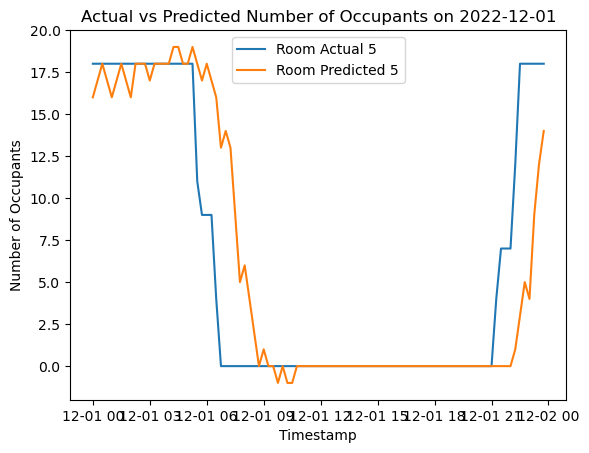

In [38]:
# create a list of all the room ids in the datasets
room_ids = list(set(actual_df['room_id']) | set(pred_df['room_id']))

# plot the actual and predicted number of occupants for each room on the selected date
    # filter the actual and predicted datasets for the current room_id
room_actual_df = actual_df[actual_df['room_id']==5]
room_pred_df = pred_df[pred_df['room_id']==5]
    
    # plot the actual and predicted number of occupants for the current room_id
plt.plot(room_actual_df['initial_timestamp'], room_actual_df['number_of_astronauts'], label='Room Actual 5')
plt.plot(room_pred_df['start_timestamp'], room_pred_df['number_of_astronauts'], label='Room Predicted 5')
    
plt.title('Actual vs Predicted Number of Occupants on '+plot_date)
plt.xlabel('Timestamp')
plt.ylabel('Number of Occupants')
plt.legend()
plt.show()

In [ ]:
pred_df.to_csv('predictions_RNN.csv', index=False)